# Modeling
## Predicting Rates of Chronic Absenteeism

### Imports 

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeClassifier 
import datetime
from pandas_profiling import ProfileReport

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn import tree, metrics
from io import StringIO  
from IPython.display import Image  
#import pydotplus

import matplotlib.style as style
style.use('fivethirtyeight')

In [2]:
#load processed data
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/data/processed'
os.chdir(path)

In [3]:
#load data for regression and classification models
df_regressor = pd.read_csv('attendance_2013_18_regressor.csv', dtype={'District_Number': object})

df_classifier = pd.read_csv('attendance_2013_18_classifier.csv', dtype={'District_Number': object})

In [4]:
#check to ensure District Number is correctly an object, not int
df_regressor.dtypes

Grade                              object
Year                               object
Demographic Variable               object
% Attendance                      float64
% Chronically Absent              float64
Next Year % Chronically Absent    float64
District_Number                    object
dtype: object

This time we will try the models by dropping `% Chronically Absent`, as this will make the models more usable/generalizable in a larger context.

In [5]:
#create dummy variables for the two data frames
df_regressor_dummies = pd.get_dummies(df_regressor.drop(columns=['% Chronically Absent']))

#remove target variable from classification data, so it does not get turned into a dummy variable
df_classifier_dummies = pd.get_dummies(df_classifier.drop(columns=['Chronically_Absent_Next_Year', '% Chronically Absent']))

#save target variable for classification
target_classifier = df_classifier['Chronically_Absent_Next_Year']

print(df_classifier_dummies.shape)
print(df_regressor_dummies.shape)

(453956, 68)
(453956, 69)


In [208]:
#define variables for regressor
X = df_regressor_dummies.drop(columns=['Next Year % Chronically Absent'])
y = df_regressor_dummies['Next Year % Chronically Absent']

In [209]:
#Time series Train test split for the 5 school years years
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Modeling

### Initial Benchmark - Dummy Regressor

In [96]:
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

27.31792586248235

In [97]:
#Fit the dummy regressor on the training data
#Then print the object's `constant_` attribute and verify it's the same as the mean above
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[27.31792586]])

In [98]:
#create dummy regressor predictions 
y_tr_pred = dumb_reg.predict(X_train)
#Make prediction with the single value of the (training) mean.
y_te_pred = train_mean * np.ones(len(y_test))
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0003902419452113115)

In [99]:
#establish baseline for mean absolute error and mean square error 
print('MAEs:', mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred))
print('MSEs:', mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred))

MAEs: 14.425187661095018 14.407710596424323
MSEs: 313.6617613921039 312.10496683625587


### Linear Regression Model

In [100]:
lm = LinearRegression().fit(X_train, y_train)

In [101]:
#Make predictions using the model on both train and test splits
y_tr_pred = lm.predict(X_train)
y_te_pred = lm.predict(X_test)

In [102]:
#Assess model performance
# r^2 - train, test
r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
print('r2:', r2)

r2: (0.6639015851045162, 0.6323296570962034)


In [103]:
#MAE - train, test
mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
print('mae:', mae)

mae: (7.6280049057708075, 8.001446269821166)


In [104]:
# MSE - train, test
mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
print('mse:', mse)

mse: (105.42122081721159, 114.70697670494565)


### Random Forest Regression Model

In [210]:
#initate model
rf_model = RandomForestRegressor()

In [211]:
#fit and score model

%%time
rf_model.fit(X_train, y_train)
y_tr_pred = rf_model.predict(X_train)
y_te_pred = rf_model.predict(X_test)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

CPU times: user 9min 33s, sys: 13.2 s, total: 9min 46s
Wall time: 10min 11s


(0.940303590508262, 0.6702007478680436)

In [212]:
#get MAE
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(3.0699642827428324, 7.359934644907501)

In [213]:
#get MSE
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(18.724480949962874, 102.89183194062339)

## Initial Classification Models

In [6]:
#define variables for classifier
X_c = df_classifier_dummies
y_c = target_classifier

In [7]:
#Time series Train test split for the 5 school years years
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X_c):
    X_train, X_test = X_c.iloc[train_index, :], X_c.iloc[test_index,:]
    y_train, y_test = y_c.iloc[train_index], y_c.iloc[test_index]

### Decision Tree

In [100]:
# training a DescisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions) 

In [101]:
print(dtree_model.score(X_test, y_test))
print(cm)
print(classification_report(y_test, dtree_predictions))

0.7609669702216524
[[ 9009    29  4131]
 [   59  7650  4442]
 [ 5738  3686 40915]]
              precision    recall  f1-score   support

        High       0.61      0.68      0.64     13169
         Low       0.67      0.63      0.65     12151
      Medium       0.83      0.81      0.82     50339

    accuracy                           0.76     75659
   macro avg       0.70      0.71      0.70     75659
weighted avg       0.76      0.76      0.76     75659



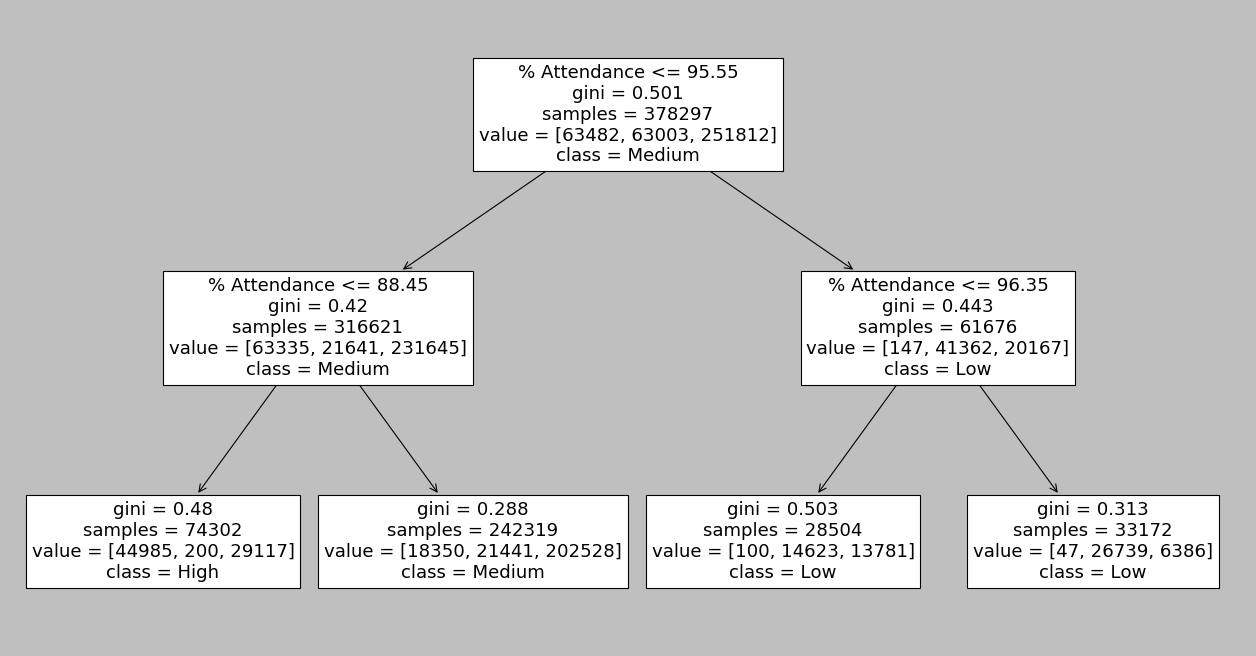

In [159]:
plt.style.use('classic')
#plot decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(dtree_model, class_names=dtree_model.classes_, feature_names=X_train.columns)
plt.show()

### Tuning Decision Tree Classifier

In [221]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": randint(1, 9),
              #"max_features": randint(1, 9),
              #"min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 6}
Best score is 0.774772201483892


In [ ]:
# Predict the labels of the test set: y_pred
y_pred = tree_cv.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [225]:
#create model with tuned hyperparameters
tuned_tree = DecisionTreeClassifier(criterion='entropy', max_depth=6)

# Fit it to the data
tuned_tree.fit(X_train, y_train)
y_pred = tree_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.75      0.45      0.57     13169
         Low       0.76      0.51      0.61     12151
      Medium       0.78      0.92      0.84     50339

    accuracy                           0.77     75659
   macro avg       0.76      0.63      0.67     75659
weighted avg       0.77      0.77      0.76     75659



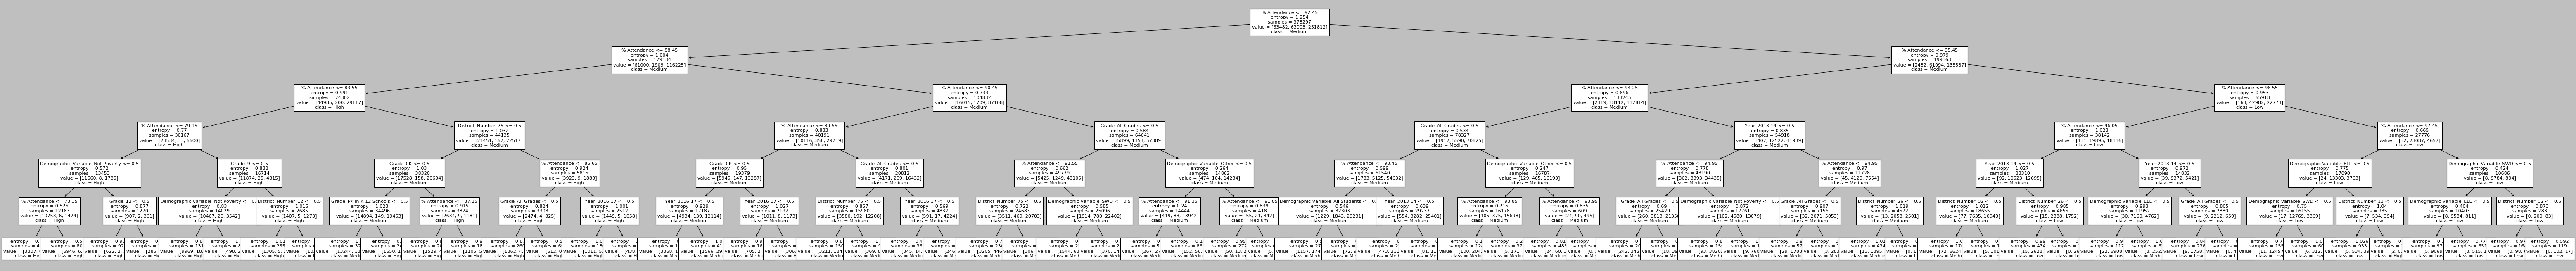

In [229]:
#plot decision tree tuned for hyperparameters
from sklearn import tree
plt.style.use('classic')
plt.figure(figsize=(100,10))
tree.plot_tree(tuned_tree, class_names=tuned_tree.classes_, feature_names=X_train.columns, fontsize=10)
plt.show()

## Naive Bayes Classifier

In [8]:
%%time
# training a Naive Bayes classifier 
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_train, y_train) 
gnb_predictions = gnb.predict(X_test) 
  
# accuracy on X_test 
accuracy = gnb.score(X_test, y_test) 
print(accuracy)
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, gnb_predictions) 

0.4905166602783542
CPU times: user 1.54 s, sys: 445 ms, total: 1.99 s
Wall time: 2.01 s


In [9]:
#print confusion matrix and classification report
print(cm)
print(classification_report(y_test, gnb_predictions))

[[10371   420  2378]
 [ 1205  9133  1813]
 [16878 15853 17608]]
              precision    recall  f1-score   support

        High       0.36      0.79      0.50     13169
         Low       0.36      0.75      0.49     12151
      Medium       0.81      0.35      0.49     50339

    accuracy                           0.49     75659
   macro avg       0.51      0.63      0.49     75659
weighted avg       0.66      0.49      0.49     75659



### Random Forest Classifier

In [236]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf_class = RandomForestClassifier().fit(X_train, y_train) 
rf_class_pred = rf_class.predict(X_test) 
  
# accuracy on X_test 
accuracy = rf_class.score(X_test, y_test) 
print(accuracy)
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, rf_class_pred) 

0.7919745172418351
CPU times: user 1min 39s, sys: 3.2 s, total: 1min 42s
Wall time: 1min 44s


In [237]:
#print confusion matrix and classification report
print(cm)
print(classification_report(y_test, rf_class_pred))

[[ 7647    18  5504]
 [   24  7245  4882]
 [ 2632  2679 45028]]
              precision    recall  f1-score   support

        High       0.74      0.58      0.65     13169
         Low       0.73      0.60      0.66     12151
      Medium       0.81      0.89      0.85     50339

    accuracy                           0.79     75659
   macro avg       0.76      0.69      0.72     75659
weighted avg       0.79      0.79      0.79     75659



In [247]:
#see tree depths of random forrest classifier
[estimator.tree_.max_depth for estimator in rf_class.estimators_]

[70,
 71,
 70,
 70,
 70,
 69,
 71,
 69,
 68,
 71,
 72,
 69,
 69,
 69,
 71,
 69,
 67,
 68,
 69,
 71,
 67,
 68,
 73,
 68,
 69,
 69,
 68,
 71,
 68,
 69,
 72,
 69,
 68,
 69,
 72,
 69,
 69,
 70,
 71,
 70,
 70,
 68,
 68,
 68,
 68,
 70,
 71,
 68,
 70,
 70,
 68,
 71,
 68,
 70,
 71,
 68,
 69,
 70,
 71,
 72,
 69,
 70,
 71,
 69,
 70,
 69,
 69,
 70,
 70,
 68,
 69,
 69,
 70,
 69,
 68,
 68,
 70,
 68,
 73,
 70,
 67,
 71,
 68,
 68,
 68,
 71,
 68,
 69,
 72,
 69,
 69,
 71,
 69,
 71,
 70,
 68,
 68,
 69,
 70,
 70]

# Tuning Random Forest Classifier

In [248]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": randint(1, 9),
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
rf_tree = RandomForestClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
rf_tree_cv = RandomizedSearchCV(rf_tree, param_dist, cv=5)

# Fit it to the data
rf_tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(rf_tree_cv.best_params_))
print("Best score is {}".format(rf_tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 6}
Best score is 0.7087499329401009


In [249]:
# Predict the labels of the test set: y_pred
y_pred = rf_tree_cv.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 2551     1 10617]
 [    7  2151  9993]
 [  611   439 49289]]
              precision    recall  f1-score   support

        High       0.80      0.19      0.31     13169
         Low       0.83      0.18      0.29     12151
      Medium       0.71      0.98      0.82     50339

    accuracy                           0.71     75659
   macro avg       0.78      0.45      0.47     75659
weighted avg       0.74      0.71      0.65     75659



### K-Nearest Neighbors

In [30]:
# Create a k-NN classifier
knn = KNeighborsClassifier()

# Fit the classifier to the data
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [31]:
# Predict the labels for the training data X
y_pred = knn.predict(X_test)

In [32]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7737612180969878


In [33]:
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 7820    38  5311]
 [   58  7175  4918]
 [ 3575  3217 43547]]
              precision    recall  f1-score   support

        High       0.68      0.59      0.64     13169
         Low       0.69      0.59      0.64     12151
      Medium       0.81      0.87      0.84     50339

    accuracy                           0.77     75659
   macro avg       0.73      0.68      0.70     75659
weighted avg       0.77      0.77      0.77     75659



#### Hyperparameter Tuning

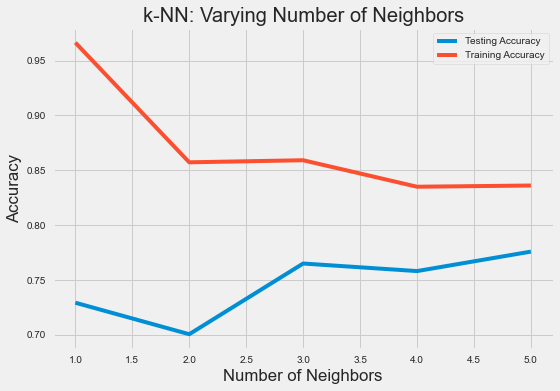

In [67]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 6)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

Tried running this for neighbors = range(6-10). This was done because running time for full range took too long.

In [198]:
test_accuracy

array([0.772])

### Tensorflow Deep Learning Regression Model

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import warnings
print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.3.1


In [73]:
#Reset TF session parameters
#tf.keras.backend.clear_session()

In [74]:
#define variables for tensorflow regressor
X = df_regressor_dummies
y = df_regressor_dummies['Next Year % Chronically Absent']

#train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Time series Train test split for the 5 school years years
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [75]:
#Split features from labels
train_features = X_train.copy()
test_features = X_test.copy()

train_labels = train_features.pop('Next Year % Chronically Absent')
test_labels = test_features.pop('Next Year % Chronically Absent')

In [76]:
#see how different the ranges of each feature are.
X_train.describe().transpose()[['mean', 'std']]

,mean,std
% Attendance,91.377751,5.304716
Next Year % Chronically Absent,27.317926,17.710522
Grade_0K,0.074849,0.263147
Grade_1,0.078748,0.269345
Grade_10,0.046159,0.209831
...,...,...
District_Number_29,0.029546,0.169330
District_Number_30,0.032741,0.177959
District_Number_31,0.049202,0.216290
District_Number_32,0.015250,0.122546


In [77]:
#build normalization layer
normalizer = preprocessing.Normalization()

In [78]:
#adapt it to the data
normalizer.adapt(np.array(train_features))

In [79]:
#this calculates the mean and variance, and stores them in the layer.
print(normalizer.mean.numpy())

[91.378  0.075  0.079  0.046  0.04   0.041  0.079  0.077  0.074  0.071
  0.045  0.044  0.045  0.049  0.209  0.028  0.229  0.236  0.243  0.246
  0.046  0.132  0.036  0.06   0.055  0.098  0.083  0.098  0.059  0.074
  0.091  0.01   0.074  0.093  0.036  0.019  0.066  0.028  0.022  0.018
  0.029  0.023  0.033  0.039  0.054  0.039  0.029  0.023  0.026  0.03
  0.011  0.027  0.016  0.026  0.033  0.031  0.028  0.014  0.037  0.033
  0.024  0.043  0.034  0.03   0.033  0.049  0.015  0.039]


#### Tensorflow Linear regression
Before building a DNN model, start with a linear regression.

In [80]:
#Build the sequential model using the Normalization layer that was adapted to the whole dataset.
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [81]:
#call this model on a batch of inputs, producing produces units=1 outputs for each example
linear_model.predict(train_features[:10])

array([[2.122],
       [0.91 ],
       [1.097],
       [1.454],
       [0.953],
       [2.93 ],
       [1.088],
       [1.698],
       [2.122],
       [0.941]], dtype=float32)

In [82]:
#configure the training procedure 
#define what will be optimized (mean_absolute_error) and how (using the optimizers.Adam)
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [83]:
#execute the training

In [84]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=20,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 3min 13s, sys: 32.5 s, total: 3min 46s
Wall time: 2min 18s


In [85]:
#Visualize the model's training progress using the stats stored in the history object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
15,7.732696,31.727478,15
16,7.736129,31.928314,16
17,7.738345,32.416481,17
18,7.741269,32.045475,18
19,7.736591,31.661232,19


In [86]:
def plot_loss(history, y_lim=10):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, y_lim])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Next Year % Chronically Absent]')
  plt.legend()
  plt.grid(True)

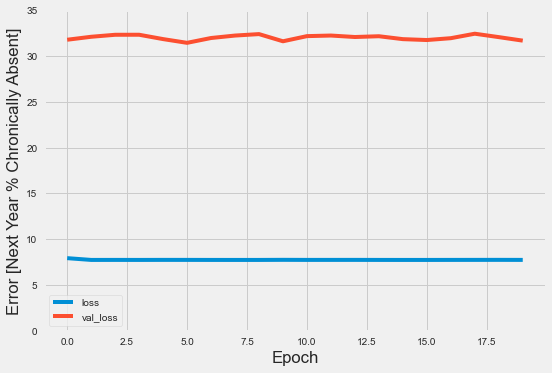

In [87]:
#visualize training and validation error
plot_loss(history, 35)

In [88]:
#Collect the results on the test set, for later:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

#### Tensorflow DNN Regression

In [89]:
#define function to build and compile the model
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(68, activation='relu'),
      layers.Dense(68, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [90]:
#Build the sequential model
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 68)                137       
_________________________________________________________________
dense_5 (Dense)              (None, 68)                4692      
_________________________________________________________________
dense_6 (Dense)              (None, 68)                4692      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 69        
Total params: 9,590
Trainable params: 9,453
Non-trainable params: 137
_________________________________________________________________


In [91]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=20)

CPU times: user 4min 45s, sys: 49.5 s, total: 5min 34s
Wall time: 2min 58s


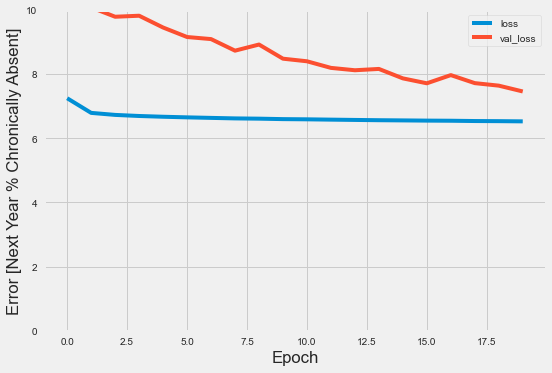

In [92]:
plot_loss(history)

In [93]:
#Collect the results on the test set:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

### Tensorflow Model Performance

In [94]:
#check the test-set performance
pd.DataFrame(test_results, index=['Mean absolute error [Next Year % Chronically Absent]']).T

,Mean absolute error [Next Year % Chronically Absent]
linear_model,109.451859
dnn_model,8.968453


Results match the validation error seen during training on dnn_model, not linear_model.

#### Make predictions

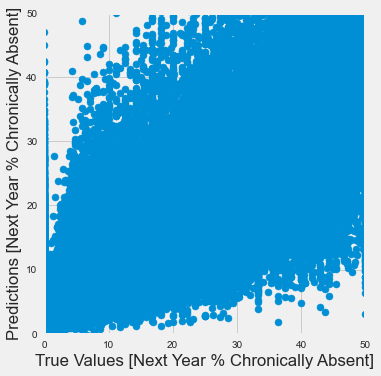

In [95]:
#look at the errors made by the model when making predictions on the test set
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Next Year % Chronically Absent]')
plt.ylabel('Predictions [Next Year % Chronically Absent]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

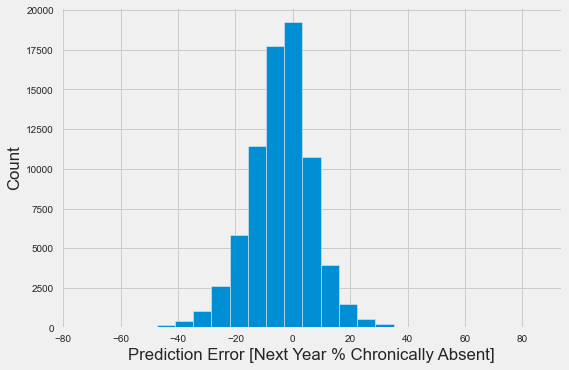

In [96]:
#look at the error distribution:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Next Year % Chronically Absent]')
_ = plt.ylabel('Count')

In [97]:
#r2_score(, y_tr_pred), 
r2_score(test_labels, test_predictions)

0.5431972650252519

## Choose Model + Feature Importance 

Best performing model is in terms of overall accuracy random forest classifier (79% Accuracy. In many cases school districs would be most focused on the 'High' rates of Chronic Absenteeism (**Meaning... insert number..)**. For the 'High' class Random forest classifer 

     
It wil depend on what a district needs to manage more, False Positives or False Negatives, in deciding which model is best in reality. 

- too many False positives = may be ok for school districts with less constraintes (ie. larger budgets, more time for this kind of initiative), as they may want to ensure they got all the schools & groups that are at risk of high chronic absenteeism.
- too many False negatives = may be ok for school disctricts with more constraints (ie. smaller budgets, less time for this kind of initiative), as they may want to ensure a school/group they focus on will really need it.


So the Random Forrest Model would be a great choice if you want to ensure you limited False Positives (and were ok with under-identifying schools/groups that are at risk of high chronic absenteeism), because the precision is higher while the recall is lower: 

'High' Next_Year_Chronic Absenteesim:
- precision: 0.74
- recall: 0.58
- f1-score: 0.65 
- support: 13169
    
However if you wanted to ensure you limited False Negatives (and were ok with over-identifying schools/groups that are at risk of high chronic absenteeism), then the Naive Bayes Classifer (49% Accuracy) would be the way to go, because although the precision is low the recall is much higher than other models:

'High' Next_Year_Chronic Absenteesim:
- precision: 0.36 
- recall: 0.79
- f1-score: 0.50
- support: 13169
  
But if you wanted the most balanced model the Descision Tree (76% accuracy) may be the best choice as its precision vs. recall for the 'High' class have the least difference.
        
'High' Next_Year_Chronic Absenteesim:
- precision: 0.61  
- recall: 0.68 
- f1-score: 0.64
- support: 13169

This model is also incredibly straightforward to explain (albeit not that helpful in new information) to schools. As it predicts any school/group that has:

- attendance above 95.5% as 'Low' Next_Year_Chronic Absenteesim 
- attendance between 88.45% and 95.5% as 'Medium' Next_Year_Chronic Absenteesim
- attendance below 88.45% as 'High' Next_Year_Chronic Absenteesim

Feature ranking:
1. feature 0 (0.605711)
2. feature 67 (0.016592)
3. feature 5 (0.012628)
4. feature 18 (0.010840)
5. feature 16 (0.010721)
6. feature 17 (0.010699)
7. feature 19 (0.010696)
8. feature 60 (0.009022)
9. feature 22 (0.008617)
10. feature 36 (0.008554)
11. feature 29 (0.008223)
12. feature 25 (0.008048)
13. feature 27 (0.007870)
14. feature 26 (0.007643)
15. feature 14 (0.007284)
16. feature 33 (0.007123)
17. feature 7 (0.006766)
18. feature 6 (0.006661)
19. feature 21 (0.006509)
20. feature 2 (0.006482)
21. feature 24 (0.006437)
22. feature 8 (0.006257)
23. feature 1 (0.006234)
24. feature 3 (0.006231)
25. feature 30 (0.006121)
26. feature 23 (0.006095)
27. feature 32 (0.006042)
28. feature 9 (0.005986)
29. feature 54 (0.005928)
30. feature 13 (0.005706)
31. feature 12 (0.005533)
32. feature 10 (0.005503)
33. feature 11 (0.005501)
34. feature 61 (0.005395)
35. feature 4 (0.005242)
36. feature 28 (0.005229)
37. feature 34 (0.005148)
38. feature 59 (0.005062)
39. feature 49

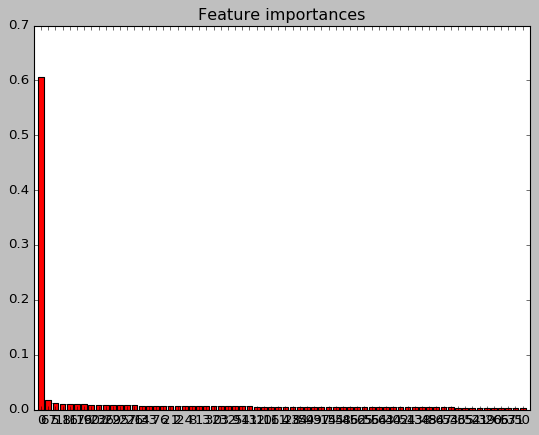

In [241]:
#plot feature importance for random forest classifier model...
importances = rf_class.feature_importances_
std = np.std([rf_class.feature_importances_ for tree in rf_class.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Feature ranking (see above for percentages):

1. '% Attendance'
2. District_Number_75
3. Grade_12
4. Year_2015-16
5. Year_2013-14
6. Year_2014-15
7. Year_2016-17
8. District_Number_26
9. Demographic Variable_Asian
10. District_Number_02

Seems to imply that:
- Attendance % by and far the greatest impact
- Certain districts have more of an impact on the model (for example District 75, which is specifically a Special education district)
- overall changes happening year to year may have larger impact feature wise.

In [268]:
print(X.columns[36])
print('full list', X.columns)

District_Number_02
full list Index(['% Attendance', 'Grade_0K', 'Grade_1', 'Grade_10', 'Grade_11',
       'Grade_12', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5', 'Grade_6',
       'Grade_7', 'Grade_8', 'Grade_9', 'Grade_All Grades',
       'Grade_PK in K-12 Schools', 'Year_2013-14', 'Year_2014-15',
       'Year_2015-16', 'Year_2016-17', 'Year_2017-18',
       'Demographic Variable_All Students', 'Demographic Variable_Asian',
       'Demographic Variable_Black', 'Demographic Variable_ELL',
       'Demographic Variable_Female', 'Demographic Variable_Hispanic',
       'Demographic Variable_Male', 'Demographic Variable_Not ELL',
       'Demographic Variable_Not Poverty', 'Demographic Variable_Not SWD',
       'Demographic Variable_Other', 'Demographic Variable_Poverty',
       'Demographic Variable_SWD', 'Demographic Variable_White',
       'District_Number_01', 'District_Number_02', 'District_Number_03',
       'District_Number_04', 'District_Number_05', 'District_Number_06',
       'Dist

### Saved Best Model

In [269]:
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/models'
os.chdir(path)

# save the random forrest classifier model to disk
filename = 'rf_classifier.sav'
pickle.dump(rf_class, open(filename, 'wb'))

In [271]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.7919745172418351


In [273]:
# save the Naive Bayes model to disk
filename_2 = 'naive_bayes.sav'
pickle.dump(gnb, open(filename_2, 'wb'))

NameError: name 'gnb' is not defined

In [ ]:
# load the model from disk
loaded_model_2 = pickle.load(open(filename_2, 'rb'))
result = loaded_model_2.score(X_test, y_test)
print(result)

## Notes 

## Summary 

- load processed data
- load data for regression and classification models
- check to ensure District Number is correctly an object, not int

- This time we will try the models by dropping % Chronically Absent, as this will make the models more usable/generalizable in a larger context.

-  create dummy variables for the two data frames
- remove target variable from classification data, so it does not get turned into a dummy variable
- save target variable for classification

- define variables for regressor
- Time series Train test split for the 5 school years years

Modeling

Initial Benchmark - Dummy Regressor
- Calculate the mean of `y_train`
- Fit the dummy regressor on the training data
- Then print the object's `constant_` attribute and verify it's the same as the mean above
- create dummy regressor predictions 
- Make prediction with the single value of the (training) mean.
- establish baseline for mean absolute error and mean square error

Linear Regression Model
- Make predictions using the model on both train and test splits
- Assess model performance
- r^2 - train, test
- MAE - train, test
- MSE - train, test

Random Forest Regression Model
- fit and score model
- get MAE
- get MSE

Initial Classification Models
- define variables for classifier
- Time series Train test split for the 5 school years

Decision Tree
- training a DescisionTreeClassifier
- creating a confusion matrix 
- plot decision tree

Tuning Decision Tree Classifier
- Setup the parameters and distributions to sample from: param_dist
- Instantiate a Decision Tree classifier: tree
- Instantiate the RandomizedSearchCV object: tree_cv
- Fit it to the data
- Print the tuned parameters and score
- Predict the labels of the test set: y_pred
- Generate the confusion matrix and classification report
- create model with tuned hyperparameters
- Fit it to the data
- plot decision tree tuned for hyperparameters

Naive Bayes classifier 
- training a Naive Bayes classifier 
- accuracy on X_test 
- creating a confusion matrix 
- print confusion matrix and classification report

Random Forest Classifier
- accuracy on X_test 
- creating a confusion matrix 
- see tree depths of random forrest classifier (mostly high 60s-low 70s)

Tuning Random Forest Classifier
- Setup the parameters and distributions to sample from: param_dist
- Instantiate a Decision Tree classifier: tree
- Instantiate the RandomizedSearchCV object: tree_cv
- Fit it to the data
- Print the tuned parameters and score
- Predict the labels of the test set: y_pred
- Generate the confusion matrix and classification report

K-Nearest Neighbors
-similar steps as above models

Tensorflow Deep Learning Regression Model
- define variables for tensorflow regressor
- Time series Train test split for the 5 school years years
- Split features from labels
- see how different the ranges of each feature are.
- build normalization layer
- adapt it to the data

Tensorflow Linear regression - Before building a DNN model, start with a linear regression.
- Build the sequential model using the Normalization layer that was adapted to the whole dataset.
- call this model on a batch of inputs, producing produces units=1 outputs for each example
- configure the training procedure 
- define what will be optimized (mean_absolute_error) and how (using the optimizers.Adam)
- execute the training
- Visualize the model's training progress using the stats stored in the history object
- visualize training and validation error
- Collect the results on the test set, for later

Tensorflow DNN Regression
- define function to build and compile the model
- Build the sequential model
- Collect the results on the test set:
- check the test-set performance
- look at the errors made by the model when making predictions on the test set

- look at the error distribution:
- r2_score

Choose Model + Feature Importance
- See notes above around this

Saved best model (Random forest regressor and naive bayes classifier)

